In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchvision.transforms import v2
from torchvision.models import resnet18, densenet121
from tqdm import tqdm
import albumentations as albu
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np

/opt/anaconda3/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from huggingface_hub import login
login()

In [3]:
from datasets import load_dataset

In [4]:
train = load_dataset("zh-plus/tiny-imagenet", split="train")
test  = load_dataset("zh-plus/tiny-imagenet", split="valid")

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None, augmentations: albu.Compose = None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform
        self.augmentations = augmentations

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        if self.augmentations:
            image = image.convert("RGB")
            image = np.array(image)
            augmented = self.augmentations(image=image)
            image = torch.from_numpy(augmented["image"]).permute(2, 0, 1)
            
        return image, label

In [6]:
# transform_train = v2.Compose([
#     v2.RandomHorizontalFlip(),
#     v2.RandomResizedCrop(224),
#     v2.ToTensor(),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
# ])
# transform_val = v2.Compose([
#     v2.Resize(256),
#     v2.CenterCrop(224),
#     v2.ToTensor(),
#     v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
# ])

# train_dataset = CustomDataset(train, transform = transform_train)
# test_dataset = CustomDataset(test, transform = transform_val)

In [7]:
transform_train = albu.Compose([
    albu.RandomResizedCrop(height=224, width=224),  # Random crop with resizing
    albu.HorizontalFlip(p=0.5),  # Random horizontal flip with a 50% chance
    #albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5),  # Random shifts, scales, and rotations
    #albu.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Random brightness/contrast/saturation/hue
    albu.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Add random blur to the image
    albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Random brightness and contrast adjustment
    #albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),  # Random changes in hue, saturation, and value
    albu.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.2), 
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])
transform_val = albu.Compose([
    albu.Resize(height=256, width=256), 
    albu.CenterCrop(height=224, width=224), 
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

train_dataset = CustomDataset(train, augmentations = transform_train)
test_dataset = CustomDataset(test, augmentations = transform_val)

In [8]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True
                         )


test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=True
                        )

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [10]:
model_conv = resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 200)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.fc.parameters())

In [11]:
def train_loop(dataloader, model, criterion, optimizer): 
    model.train()
    losses = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(dataloader)):
        data = data.to(device=device)
        targets = targets.to(device=device)
    
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())
    
        optimizer.zero_grad()
    
        loss.backward()
    
    
        optimizer.step()

    logs = {"losses": np.array(losses)}

    return logs

In [12]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)

            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"           {num_correct} / {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples):.3f}"
        )
    
    model.train()
    
    return float(num_correct) / float(num_samples)

In [13]:
num_epochs = 10

In [14]:
losses=[]
scores = []
lowest_loss = float('inf')
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    train_logs = train_loop(train_loader, model_conv, criterion, optimizer_conv)
    losses.append(np.mean(train_logs["losses"]))

    avg_loss = np.sum(train_logs["losses"])/ len(train_loader)
    if avg_loss < lowest_loss:
        print(f'New lowest loss: {avg_loss}. Saving model...')
        best_params = model_conv.state_dict()
        lowest_loss = avg_loss
        
    print(f"          loss: {losses[-1]:.3f}")
    score = check_accuracy(test_loader, model_conv)
    scores.append(score)

Epoch: 0


100%|███████████████████████████████████████| 1563/1563 [09:26<00:00,  2.76it/s]


New lowest loss: 3.7005226384807837. Saving model...
          loss: 3.701


100%|█████████████████████████████████████████| 157/157 [00:47<00:00,  3.32it/s]


           4231 / 10000 with accuracy 0.423
Epoch: 1


100%|███████████████████████████████████████| 1563/1563 [48:19<00:00,  1.86s/it]


New lowest loss: 3.1716797502850844. Saving model...
          loss: 3.172


100%|█████████████████████████████████████████| 157/157 [00:35<00:00,  4.45it/s]


           4562 / 10000 with accuracy 0.456
Epoch: 2


100%|███████████████████████████████████████| 1563/1563 [08:58<00:00,  2.90it/s]


New lowest loss: 3.0926063350584747. Saving model...
          loss: 3.093


100%|█████████████████████████████████████████| 157/157 [00:45<00:00,  3.43it/s]


           4532 / 10000 with accuracy 0.453
Epoch: 3


100%|███████████████████████████████████████| 1563/1563 [09:48<00:00,  2.65it/s]


New lowest loss: 3.0614714119118602. Saving model...
          loss: 3.061


100%|█████████████████████████████████████████| 157/157 [00:52<00:00,  3.00it/s]


           4675 / 10000 with accuracy 0.468
Epoch: 4


100%|███████████████████████████████████████| 1563/1563 [10:17<00:00,  2.53it/s]


New lowest loss: 3.047256177766767. Saving model...
          loss: 3.047


100%|█████████████████████████████████████████| 157/157 [00:52<00:00,  2.97it/s]


           4673 / 10000 with accuracy 0.467
Epoch: 5


100%|███████████████████████████████████████| 1563/1563 [10:15<00:00,  2.54it/s]


New lowest loss: 3.039154429048281. Saving model...
          loss: 3.039


100%|█████████████████████████████████████████| 157/157 [00:53<00:00,  2.93it/s]


           4748 / 10000 with accuracy 0.475
Epoch: 6


100%|███████████████████████████████████████| 1563/1563 [10:15<00:00,  2.54it/s]


New lowest loss: 3.0179035131243355. Saving model...
          loss: 3.018


100%|█████████████████████████████████████████| 157/157 [00:52<00:00,  3.00it/s]


           4753 / 10000 with accuracy 0.475
Epoch: 7


100%|███████████████████████████████████████| 1563/1563 [10:08<00:00,  2.57it/s]


New lowest loss: 3.0088607442737465. Saving model...
          loss: 3.009


100%|█████████████████████████████████████████| 157/157 [00:50<00:00,  3.09it/s]


           4714 / 10000 with accuracy 0.471
Epoch: 8


100%|███████████████████████████████████████| 1563/1563 [09:58<00:00,  2.61it/s]


New lowest loss: 3.005090442744113. Saving model...
          loss: 3.005


100%|█████████████████████████████████████████| 157/157 [00:50<00:00,  3.11it/s]


           4793 / 10000 with accuracy 0.479
Epoch: 9


100%|███████████████████████████████████████| 1563/1563 [09:57<00:00,  2.62it/s]


New lowest loss: 2.9891203674687383. Saving model...
          loss: 2.989


100%|█████████████████████████████████████████| 157/157 [00:50<00:00,  3.11it/s]

           4782 / 10000 with accuracy 0.478


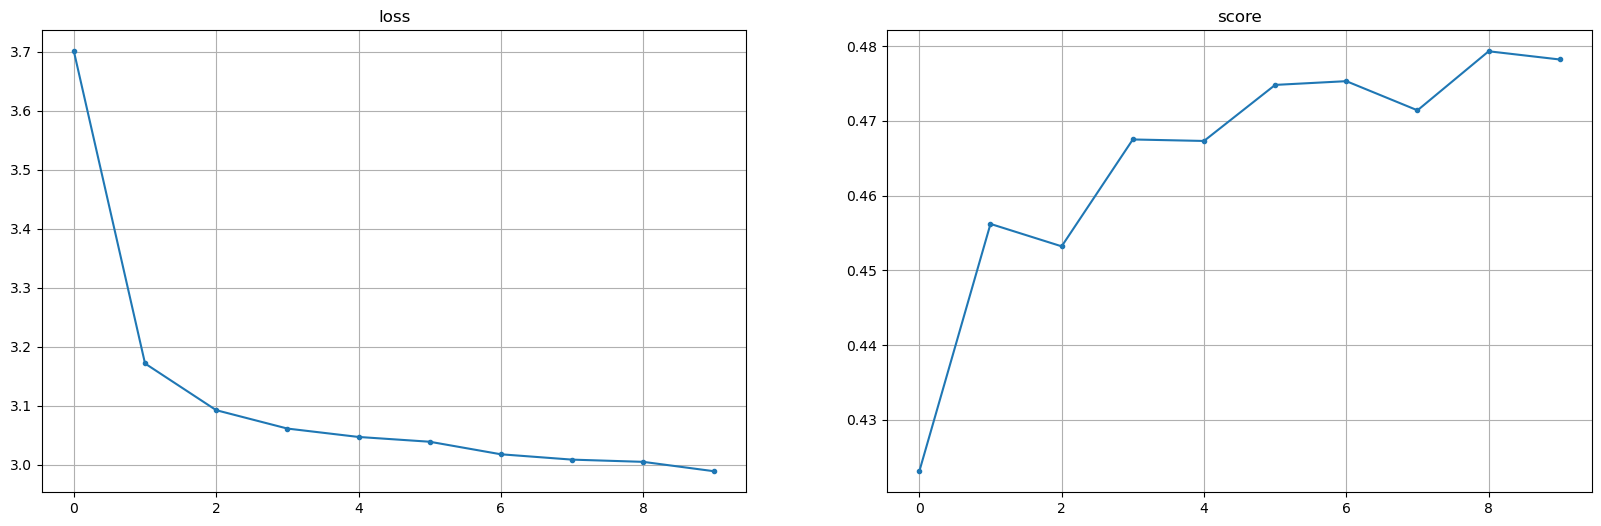

In [15]:
fix, axes = plt.subplots(ncols=2, figsize=(20, 6))

axes[0].plot(np.arange(len(losses)), losses, ".-")
axes[0].set_title("loss")
axes[0].grid()

axes[1].plot(np.arange(len(scores)), scores, '.-')
axes[1].set_title("score")
axes[1].grid()